# Corpus and BGRF Composition

We describe and analyse the status quo of the corpus with respect to criteria like author gender, year of first publication, narrative form etc. Then we compare it to the "baseline" of the Bibliographie du genre romanesque français, 1751-1800 (BGRF).

**Table of Contents**
* [Prerequisites](#Prerequisites)
  - [Import](#Import-all-necessary-python-libraries)
  - [Load corpus Metadata](#Corpus-Metadata)
  - [BGRF Metadata from Wikibase](#BGRF-Metadata-from-Wikibase)
    - [Configuration](#Configuration)
    - [Data Loading](#Data-Loading)
* [Author Gender](#Author-gender)
  - [Author Gender corpus](#Author-Gender-Corpus)
  - [Author Gender BGRF](#Author-Gender-(BGRF))
  - [Comparison](#comparison-by-decades)
* [Publication Date](#Publication-date)
  - [Publication Date](#Year-of-first-publication)
  - [Publication Date](#Publication-Date-(BGRF))
  - [Comparison](#Publication-Date-(Corpus-vs-BGRF))
* [Narrative Form](#Narrative-Form)
  - [Narrative Form corpus](#Narrative-Form-corpus)
  - [Narrative Form](#Narrative-Form-(BGRF))
  - [Comparison](#Narrative-Form-(Corpus-vs-BGRF))

## Prerequisites

### Import all necessary python libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from os.path import join
import seaborn as sns
sns.set()

# Install with e.g. `pip install sparqlwrapper`
from SPARQLWrapper import SPARQLWrapper, JSON
import sys

# Make plots appear directly in the notebook.
%matplotlib inline

from pprint import pprint

import gender_guesser.detector as gg
import re

C:\Users\Administrator\anaconda\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


### Corpus Metadata

Load the corpus metadata from the MiMoText-Github-page as DataFrame and show all metadata available as well as the number of novel files included in the metadata table.

In [2]:
# Adjust the URL to the .tsv file as needed.
DATA_URL = 'https://raw.githubusercontent.com/MiMoText/roman18/master/XML-TEI/xml-tei_full_metadata.tsv'
xml_tei_metadata = pd.read_csv(DATA_URL, sep='\t', encoding="utf8")
print('Available column names:', xml_tei_metadata.columns.values)
print("amount of texts in corpus: ", len(xml_tei_metadata))

Available column names: ['filename' 'au-name' 'au-birth' 'au-death' 'title' 'au-gender'
 'firsted-yr' 'printSource-yr' 'form' 'spelling' 'data-capture'
 'token count' 'vols_count' 'size' 'bgrf' 'author_wikidata'
 'title_wikidata' 'lang' 'publisher' 'distributor' 'distribution_date'
 'copyright_status' 'digitalSource_Title' 'digitalSource_Ref'
 'digitalSource_Publisher' 'digitalSource_Date' 'printSource_title'
 'printSource_author' 'printSource_pubPlace' 'printSource_publisher'
 'printSource_date' 'resp_datacapture' 'resp_encoding']
amount of texts in corpus:  205


Some of the metadata is not necessary for the script, so we can drop those columns to size down the DataFrame a little bit.

In [3]:
xml_tei_metadata.drop(columns=['filename', 'au-name', 'au-birth', 'au-death', 'title', 'spelling', 'data-capture', 'vols_count', 'author_wikidata', 'title_wikidata', 'lang','publisher','distributor','distribution_date', 'copyright_status','digitalSource_Title', 'digitalSource_Ref', 'digitalSource_Publisher','digitalSource_Date', 'printSource_title','printSource_author', 'printSource_publisher', 'resp_datacapture', 'resp_encoding'], inplace=True)

print('Available column names:', xml_tei_metadata.columns.values)

Available column names: ['au-gender' 'firsted-yr' 'printSource-yr' 'form' 'token count' 'size'
 'bgrf' 'printSource_pubPlace' 'printSource_date']


As we have some data that does not match the BGRF criteria like the first publication date, we will drop those for better comparison. Some of the texts therefore don't have a BGRF-ID, so lets check for it and drop those.

In [4]:
print("Number of texts in corpus: ", len(xml_tei_metadata))
xml_tei_metadata = xml_tei_metadata.drop(xml_tei_metadata[(xml_tei_metadata["bgrf"] == "0") | (xml_tei_metadata["bgrf"] == "1")].index)
print("Number of texts that do have a bgrf-id: ", len(xml_tei_metadata))

xml_tei_metadata = xml_tei_metadata.sort_values(by=["bgrf"])

Number of texts in corpus:  205
Number of texts that do have a bgrf-id:  201


### BGRF Metadata from Wikibase
Data is pulled from the MiMoText-Wikibase.

#### Configuration

#### Data Loading

We can use the Wrapper to query the MiMoTextBase:

In [5]:

endpoint_url = "https://query.mimotext.uni-trier.de/proxy/wdqs/bigdata/namespace/wdq/sparql"

query = """PREFIX mmd:<http://data.mimotext.uni-trier.de/entity/>
PREFIX mmdt:<http://data.mimotext.uni-trier.de/prop/direct/> 
PREFIX wd: <http://www.wikidata.org/entity/> #wikidata wd
PREFIX wdt: <http://www.wikidata.org/prop/direct/> #wikidata wdt

SELECT DISTINCT ?item ?authorLabel ?genderLabel (YEAR(?pubDate) as ?pubyear) ?narrFormLabel ?bgrf
WHERE{
  ?item mmdt:P2 mmd:Q2; 
  VALUES (?hasAuthor) {(mmdt:P5) (mmdt:P6)}
  ?item ?hasAuthor ?author.
  OPTIONAL{?item mmdt:P9 ?pubDate.}# publication date
  OPTIONAL{?item mmdt:P33 ?narrForm.}# narr Form
  OPTIONAL{?item mmdt:P22 ?bgrf.}# bgrf-id
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
  
  OPTIONAL{?author mmdt:P13 ?wikimatch.
  SERVICE <https://query.wikidata.org/sparql> {
  OPTIONAL{?wikimatch wdt:P21 ?gender.
            ?gender rdfs:label ?genderLabel.
             FILTER(LANG(?genderLabel)="en").
            }
  } 
 }
}
        """


def get_results(endpoint_url, query):
    user_agent = "jupyter notebook"
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    return sparql.query().convert()["results"]["bindings"]


results = get_results(endpoint_url, query)
wikibase_df = pd.json_normalize(results)


In [6]:
print(wikibase_df.columns.to_list())

['genderLabel.xml:lang', 'genderLabel.type', 'genderLabel.value', 'item.type', 'item.value', 'bgrf.type', 'bgrf.value', 'authorLabel.xml:lang', 'authorLabel.type', 'authorLabel.value', 'pubyear.datatype', 'pubyear.type', 'pubyear.value', 'narrFormLabel.xml:lang', 'narrFormLabel.type', 'narrFormLabel.value']


Now we need to drop some of the unneccessary items like the language specifier.

In [7]:
wikibase_df.drop(columns=['genderLabel.xml:lang', 'genderLabel.type','item.type','bgrf.type','authorLabel.xml:lang', 'authorLabel.type','pubyear.datatype', 'pubyear.type','narrFormLabel.xml:lang', 'narrFormLabel.type'], inplace=True)

wikibase_df.rename(columns={'pubyear.value':"year", "bgrf.value":"bgrf", "genderLabel.value":"gender", 'narrFormLabel.value': "form"}, inplace=True)

In [8]:
print(wikibase_df)

      gender                                      item.value    bgrf  \
0       male  http://data.mimotext.uni-trier.de/entity/Q1901   76.17   
1       male  http://data.mimotext.uni-trier.de/entity/Q2421   91.13   
2       male  http://data.mimotext.uni-trier.de/entity/Q1735   70.32   
3       male  http://data.mimotext.uni-trier.de/entity/Q1025    61.6   
4       male  http://data.mimotext.uni-trier.de/entity/Q1738   70.36   
...      ...                                             ...     ...   
1759    male  http://data.mimotext.uni-trier.de/entity/Q2158   84.65   
1760  female  http://data.mimotext.uni-trier.de/entity/Q1667   68.54   
1761    male  http://data.mimotext.uni-trier.de/entity/Q1668   68.56   
1762    male  http://data.mimotext.uni-trier.de/entity/Q2698  99.174   
1763    male  http://data.mimotext.uni-trier.de/entity/Q2486   93.19   

                            authorLabel.value  year            form  
0            CARMONTELLE, Louis Carrogis, dit  1776  heterodieget

Fill missing values:

In [9]:
wikibase_df.fillna("unknown")

,gender,item.value,bgrf,authorLabel.value,year,form
0,male,http://data.mimotext.uni-trier.de/entity/Q1901,76.17,"CARMONTELLE, Louis Carrogis, dit",1776,heterodiegetic
1,male,http://data.mimotext.uni-trier.de/entity/Q2421,91.13,"BOULARD, Martin-Sylvestre",1791,autodiegetic
2,male,http://data.mimotext.uni-trier.de/entity/Q1735,70.32,"CAILHAVA DE L’ESTENDOUX, Jean-François",1770,autodiegetic
3,male,http://data.mimotext.uni-trier.de/entity/Q1025,61.6,"BOUFFLERS, Stanislas-Jean, marquis de",1761,autodiegetic
4,male,http://data.mimotext.uni-trier.de/entity/Q1738,70.36,"CASTILHON, Jean",1770,heterodiegetic
...,...,...,...,...,...,...
1759,male,http://data.mimotext.uni-trier.de/entity/Q2158,84.65,"VOLTAIRE, François-Marie Arouet de",1784,unknown
1760,female,http://data.mimotext.uni-trier.de/entity/Q1667,68.54,"VILLENEUVE, Gabrielle-Suzanne Barbot de",1768,heterodiegetic
1761,male,http://data.mimotext.uni-trier.de/entity/Q1668,68.56,"VOLTAIRE, François-Marie Arouet de",1768,heterodiegetic
1762,male,http://data.mimotext.uni-trier.de/entity/Q2698,99.174,"VILLEMAIN D’ABANCOURT, François-Jean",1799,autodiegetic


#### Add additional data

In [10]:
# copy dataframes to leave them untouched if we want to use them later again
wikibase_data = wikibase_df.copy()
corpus = xml_tei_metadata.copy()

## add origin as column for combination later
corpus["origin"] = "corpus"
wikibase_data["origin"] = "wikibase"

In [11]:
wikibase_data = wikibase_data.fillna("unknown")

In [12]:
print(wikibase_data["gender"].value_counts(dropna=False))

male       838
unknown    731
female     195
Name: gender, dtype: int64


As there is currently no gender information within the MiMoText-Wikibase, we used a federated query to wikidata to get the values. Not all of the authors within the MiMoTextBase have a Wikidata-Entry, so we use the gender guesser to estimate the gender. Some of the authors don't have a first name, which will lead to "unknown", others contain titles in their name like "baron" or "baronesse" which can be categorzied beforehand.

In [13]:
## Add gender to wikibase
dec = gg.Detector()
# get author gender based on the first name of the authors
print("Counts before inserting gender: ", wikibase_data["gender"].value_counts(), "\n")
print(wikibase_data.shape, "\n")

wikibase_data["gender2"] = "unknown"
wikibase_data["prename_new"] = ""

female_names = ["madame","mademoiselle","comtesse","baronne","marquise"]
male_names = ["abbé","avocat","chevalier","baron","comte","marquis","père","duc"]

comb_m = '(?:%s)' % '|'.join(male_names)
comb_f = '(?:%s)' % '|'.join(female_names)
for i, row in wikibase_data.iterrows():
    name = row["authorLabel.value"].strip()
    if row["gender"] == "unknown":
    # print(row)
        if re.search(comb_m, name):
            wikibase_data["gender2"].loc[i] = "male"
        elif re.search(comb_f, name):
            wikibase_data["gender2"].loc[i] = "female"
        else:
            wikibase_data["gender2"].loc[i]= "unknown"  

for i, row in wikibase_data.iterrows():
    name = row["authorLabel.value"]
        #print(row)
    if row["gender"] == "unknown" and row["gender2"] == "unknown":
        try:
            name = name.split(',')[1].split('-')[0].strip()
            if re.search(" É", name):
                name = re.sub("É", "E", name) # Étienne not in gg, but Etienne is
            elif re.search("\((.*?)\)", name):
                name = re.sub("\((.*?)\)", "", name)
            elif re.search(" de", name) or re.search("d’", name):
                name = re.sub(" de", "", name)
                name = re.sub("d’", "", name)
            
            elif name == "de": # name consists of only "de"
                wikibase_data["gender2"].loc[i]= "unknown"
            elif re.search("[A-Z]{1}\.", name): # name consists of only abbreviation
                wikibase_data["gender2"].loc[i]= "unknown"
            else:
                name = name
                gender = dec.get_gender(name.strip())
                wikibase_data["gender2"].loc[i] = gender
        except IndexError:
            wikibase_data["gender2"].loc[i]= "unknown"
for i, row in wikibase_data.iterrows():
    if row["gender"] == "unknown" and row["gender2"] != "unknown":
        wikibase_data["gender"].loc[i] = wikibase_data["gender2"].loc[i]
wikibase_data["gender"] = wikibase_data["gender"].apply(lambda x: "male" if x =="mostly_male" or x == "andy" else x)       
print("Counts after inserting gender: ", wikibase_data["gender"].value_counts())
print(wikibase_data.shape)

Counts before inserting gender:  male       838
unknown    731
female     195
Name: gender, dtype: int64 

(1764, 7) 

Counts after inserting gender:  male       1013
unknown     517
female      234
Name: gender, dtype: int64
(1764, 9)


Genders in the Metadata of the Corpus have the categories "F", "M" and "U" which are going to be changed to "female", "male" and "unknown".

In [14]:
# map F as female, M as male and U as unknown in corpus to match with detected String labels from gender detector
corpus["gender"] = corpus["au-gender"]
corpus["gender"] = corpus["gender"].map(lambda x: "female" if x == "F" else x)
corpus["gender"] = corpus["gender"].map(lambda x: "male" if x == "M" else x)
corpus["gender"] = corpus["gender"].map(lambda x: "unknown" if x == "U" else x)

### Combine wikidata and metadata-Table to one table

##### Choose year and Add decades

As not all dates of publication within the metadata and BGRF match exactly, you can choose whether to use the "firsted-yr" or the year based on the BGRF as first publication date.

In [15]:
## add year based on bgrf because it can differ from firsted-yr
# with only the first two digits of the bgrf which represent the years of the first publication
# if it does not have a bgrf we cast it as 1801

corpus["bgrf_year"] = corpus["bgrf"].map(lambda x: int(x.split(".")[0]) if x != "0" else 1)
corpus["bgrf_year"] = corpus["bgrf_year"].map(lambda x: 1700+x if x in range(50,100) else 1800+x)

# change dates to datetime-format
corpus["bgrf_year"] = pd.to_datetime(corpus['bgrf_year'], format='%Y')
corpus["firsted-yr"] = pd.to_datetime(corpus['firsted-yr'], format='%Y')

# print corpus
corpus

,au-gender,firsted-yr,printSource-yr,form,token count,size,bgrf,printSource_pubPlace,printSource_date,origin,gender,bgrf_year
144,M,1800-01-01,1800,epistolary,51102,medium,00.117,Paris,1800,corpus,male,1800-01-01
145,M,1800-01-01,1800,heterodiegetic,20215,short,00.119,Paris,1800,corpus,male,1800-01-01
148,M,1800-01-01,1802,heterodiegetic,19292,short,00.120,Paris,1802,corpus,male,1800-01-01
147,M,1800-01-01,1823,heterodiegetic,21942,short,00.122,Paris,1823,corpus,male,1800-01-01
153,M,1800-01-01,1799,autodiegetic,43994,short,00.127,Paris,1799,corpus,male,1800-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...
30,M,1799-01-01,1799,heterodiegetic,47057,short,99.44,"Hambourg, Brunswick, Paris, Londres, Leipzig, ...",1799,corpus,male,1799-01-01
53,M,1799-01-01,1798-1799,heterodiegetic,83995,short,99.57,Paris,1798-1799,corpus,male,1799-01-01
59,F,1798-01-01,1824,epistolary,40093,short,99.62,Paris,1824,corpus,female,1799-01-01
77,M,1798-01-01,1798,heterodiegetic,72573,medium,99.76,Paris,1798,corpus,male,1799-01-01


Now let's check how many of the firsted-yr and the bgrf-year don't correlate:

In [16]:
not_machting_counter = 0
for i, row in corpus.iterrows():
    if row["firsted-yr"] != "nan" and row["firsted-yr"] != row["bgrf_year"]:
        not_machting_counter += 1
print("number of texts that don't have matching bgrf and firsted-yr first year publications: ", not_machting_counter)

number of texts that don't have matching bgrf and firsted-yr first year publications:  32


Choose whether to use the generated bgrf-year or the first publication year from the metadata table. As default the bgrf-year is chosen.

In [17]:
corpus["year"] = corpus["bgrf_year"] # or "firsted-yr"

Now we can combine the to dataframes.

In [18]:
wikibase_data["year"] = pd.to_datetime(wikibase_data["year"], format="%Y")

combined = pd.concat([corpus, wikibase_data], ignore_index=True)

print(combined.columns.to_list())
combined = combined.drop(columns=["au-gender",  "authorLabel.value", "gender2", "prename_new"])
print(combined.columns.to_list())


['au-gender', 'firsted-yr', 'printSource-yr', 'form', 'token count', 'size', 'bgrf', 'printSource_pubPlace', 'printSource_date', 'origin', 'gender', 'bgrf_year', 'year', 'item.value', 'authorLabel.value', 'gender2', 'prename_new']
['firsted-yr', 'printSource-yr', 'form', 'token count', 'size', 'bgrf', 'printSource_pubPlace', 'printSource_date', 'origin', 'gender', 'bgrf_year', 'year', 'item.value']


In [19]:
print(combined)

     firsted-yr printSource-yr            form  token count    size    bgrf  \
0    1800-01-01           1800      epistolary      51102.0  medium  00.117   
1    1800-01-01           1800  heterodiegetic      20215.0   short  00.119   
2    1800-01-01           1802  heterodiegetic      19292.0   short  00.120   
3    1800-01-01           1823  heterodiegetic      21942.0   short  00.122   
4    1800-01-01           1799    autodiegetic      43994.0   short  00.127   
...         ...            ...             ...          ...     ...     ...   
1960        NaT            NaN         unknown          NaN     NaN   84.65   
1961        NaT            NaN  heterodiegetic          NaN     NaN   68.54   
1962        NaT            NaN  heterodiegetic          NaN     NaN   68.56   
1963        NaT            NaN    autodiegetic          NaN     NaN  99.174   
1964        NaT            NaN         unknown          NaN     NaN   93.19   

     printSource_pubPlace printSource_date    origi

Next we can add decades based on the year.

In [20]:

decades_to_map = [(1750, 1759, "1750s"), (1760, 1769, "1760s"), (1770, 1779, "1770s"), (1780, 1789, "1780s"), (1790, 1799, "1790s"), (1800, "1800")]
for dec in decades_to_map:
    if len(dec) == 3:
        combined.loc[(combined["year"].dt.year.between(dec[0], dec[1])), "decade"] = dec[2]
    else:
        combined.loc[(combined["year"].dt.year==dec[0]), "decade"] = dec[1]

## Author Gender


### Author Gender Corpus
Data is in the column 'au-gender'. Possible values are 'F', 'M' and 'U'.

In [21]:
print(combined[combined["origin"]=="corpus"]["gender"].value_counts(normalize=True).round(3).reset_index().rename(columns={"index":"gender", "gender":"percentage"}))

print(combined[combined["origin"]=="corpus"]["gender"].value_counts().index)

    gender  percentage
0     male       0.791
1   female       0.179
2  unknown       0.030
Index(['male', 'female', 'unknown'], dtype='object')


Set of all occuring values: {'female', 'male', 'unknown'}
Percent of all genders in corpus 
 male       0.791
female     0.179
unknown    0.030
Name: gender, dtype: float64
Counts of all genders in corpus 
 male       159
female      36
unknown      6
Name: gender, dtype: int64


Text(0.5, 1.0, 'Counts in percent')

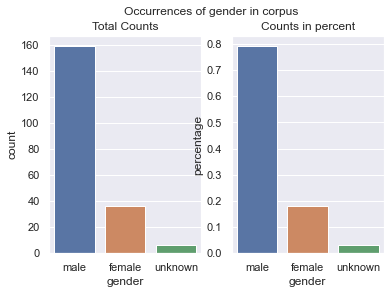

In [22]:
#bgrf_year_corpus = combined[combined["origin"]=="corpus"]["bgrf_year"].dt.year

print('Set of all occuring values:', set(combined[combined["origin"]=="corpus"]["gender"].values))
print("Percent of all genders in corpus \n",combined[combined["origin"]=="corpus"]["gender"].value_counts(normalize=True).round(3))
print("Counts of all genders in corpus \n",combined[combined["origin"]=="corpus"]["gender"].value_counts().round(3))
## Visualization in total counts:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.suptitle("Occurrences of gender in corpus")
sns.countplot(x=combined[combined["origin"]=="corpus"]["gender"], 
              order=combined[combined["origin"]=="corpus"]["gender"].value_counts().index, ax=ax1)
sns.barplot(data=combined[combined["origin"]=="corpus"]["gender"].value_counts(normalize=True).round(3).reset_index().rename(columns={"index":"gender", "gender":"percentage"}).sort_values(by="percentage", ascending=False),
             x="gender", y="percentage", ax=ax2)
ax1.set_title('Total Counts')
ax2.set_title('Counts in percent')

### Author Gender (Wikibase)


    gender    per
0     male  0.574
1  unknown  0.293
2   female  0.133


Text(0, 0.5, 'Percent in wikidata')

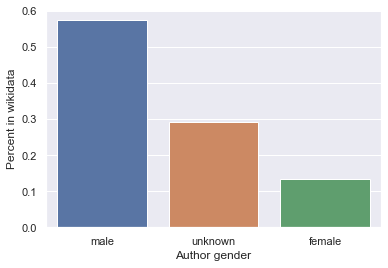

In [23]:
wikibase_gender_per = wikibase_data["gender"].value_counts(normalize=True).round(3).reset_index()
wikibase_gender_per.columns = ["gender", "per"]

print(wikibase_gender_per)
sns.barplot(data=wikibase_gender_per, x="gender", y="per")
plt.xlabel('Author gender')
plt.ylabel('Percent in wikidata')


### Comparison

#### Comparison of gender proportion in corpus and in wikibase


Text(0, 0.5, 'proportion')

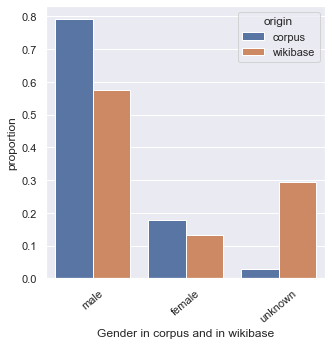

In [24]:

authors_grouped = combined.groupby(["origin"])["gender"].value_counts(normalize=True).reset_index(name="percentage")

fig, ax = plt.subplots(figsize=(5,5))
ax = sns.barplot(x="gender", y="percentage", hue="origin", data=authors_grouped)
plt.xticks(rotation=40)
plt.xlabel("Gender in corpus and in wikibase")
plt.ylabel("proportion")

We can see that the "unknown" annotated genders in the wikibase is quite high; that results of many authors that do not have a prename or a title like "comte" or "comtesse" which we covered in the previous part.
So for a "better" comparison we could remove all unknown gender data. This we will do in the following part where the genders will be compared within the decades.

#### Comparison by decades

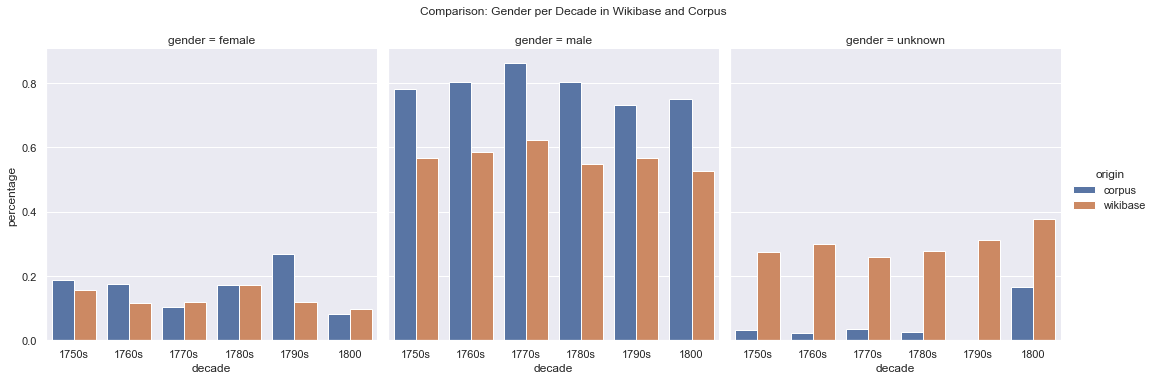

In [25]:
authors_decades = combined[["origin", "decade", "gender"]].groupby(["origin", "decade"]).value_counts(normalize=True, sort=False).reset_index(name="percentage")

# plot the data
sns.catplot(x="decade", y="percentage", hue="origin", col="gender", data=authors_decades, kind="bar")
plt.suptitle("Comparison: Gender per Decade in Wikibase and Corpus", y=1.05)
fig.tight_layout()


As we can see, the "unknown" gender in the xml-tei-corpus is so small that it is not quite visible in the visualization. Also the gender in the wikibase is based on the gender-guesser who cannot map all of the authors' names (e.g. only surnames etc.).
So in the following visualization we will drop the "unknown".

Text(0.5, 1.05, 'Comparison: Gender per Decade in Wikibase and Corpus without unknown gender')

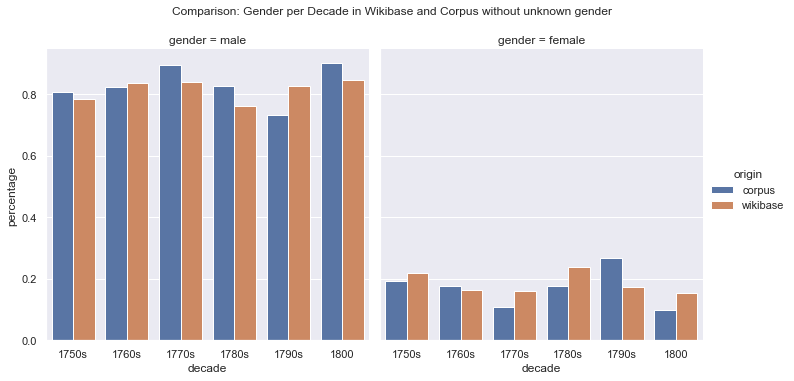

In [26]:
authors_wo_unknown = combined.drop(combined[(combined["gender"] == "unknown")].index)

authors_wo_unknown = authors_wo_unknown[["origin", "decade", "gender"]].groupby(["origin", "decade"]).value_counts(normalize=True).reset_index(name="percentage")
sns.catplot(x="decade", y="percentage", hue="origin", col="gender", data=authors_wo_unknown, kind="bar")
plt.suptitle("Comparison: Gender per Decade in Wikibase and Corpus without unknown gender", y=1.05)

## Publication Date

### Corpus Year of first publication
Data is in the column 'firsted-yr'. However, possible values can be single years `(yyyy)`, year spans `(yyyy-yyyy)`, the floating point number value `NaN`, or even a string like `'unknown'`. Therefore, we need to clean up a bit before we can use it. In case of year ranges, we simply use the first year.

If we run the cell below, we can check the first edition year and the bgrf numbers, where we will see that they differ a little bit, which can be caused by different sources of the first year information. Also there are few texts in the corpus that are not listed in the Bibliographie as novels, but we considered as interesting. For comparison though we will drop those now.

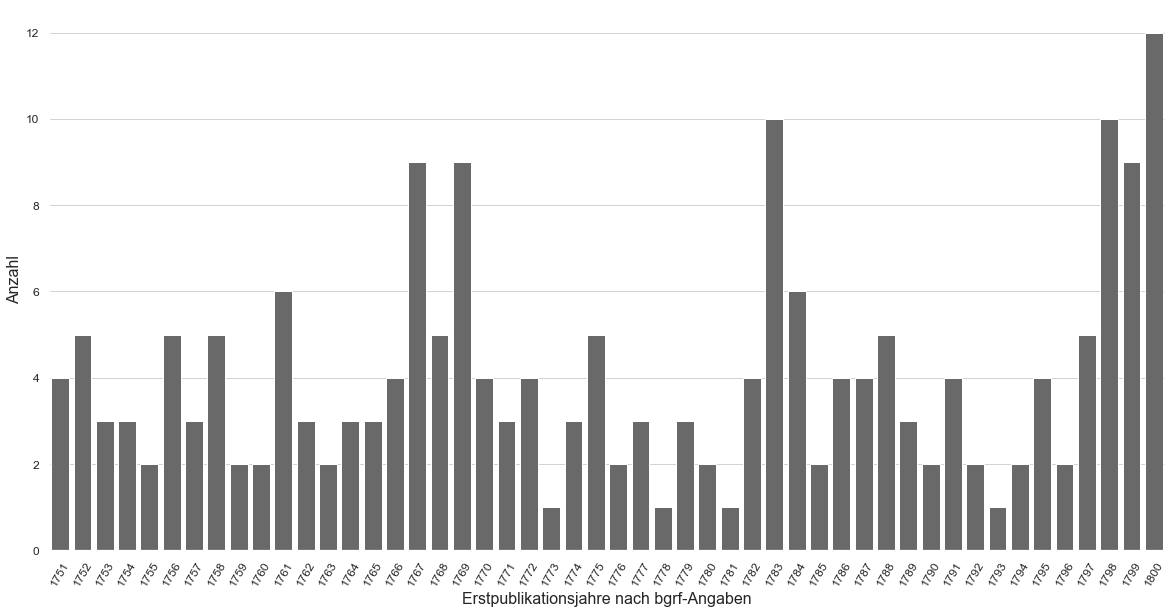

In [27]:
## Visualization of first year of publication in metadata

## Erstpublikation nach firsted-yr
firsted_corpus_sorted_yr = corpus["firsted-yr"].dt.year
firsted_corpus_sorted_yr = firsted_corpus_sorted_yr.drop(index=list(firsted_corpus_sorted_yr[firsted_corpus_sorted_yr=="nan"].index)).sort_values()

## Erstpublikation nach bgrf-Angabe in metadaten:
firsted_corpus_sorted_bgrf = corpus["bgrf_year"].dt.year.sort_values()
firsted_corpus_sorted_bgrf = firsted_corpus_sorted_bgrf.drop(index=list(firsted_corpus_sorted_bgrf[firsted_corpus_sorted_bgrf==1801].index)).sort_values()

def get_countplot_first_pub(df, col):

    fig, ax = plt.subplots(figsize=(20,10))

    sns.countplot(x=df, color="dimgrey")
    ax.set_facecolor(color="white")
    plt.xticks(rotation = 60, fontsize=12)
    plt.yticks(fontsize=12)
 
    plt.ylabel("Anzahl", fontsize=16)
    plt.grid(color="lightgrey", axis='y')

    if col == "bgrf":
        plt.xlabel("Erstpublikationsjahre nach bgrf-Angaben", fontsize=16)
    else:
        plt.xlabel("Erstpublikationsjahre nach firsted-yr", fontsize=16)
    #plt.savefig("Erstpublikationsjahre_grey.png", dpi=300)
#get_countplot_first_pub(firsted_corpus_sorted_yr, "first-yr")
get_countplot_first_pub(firsted_corpus_sorted_bgrf, "bgrf")

#### Visualization of publication year in corpus

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 <a list of 50 Text major ticklabel objects>)

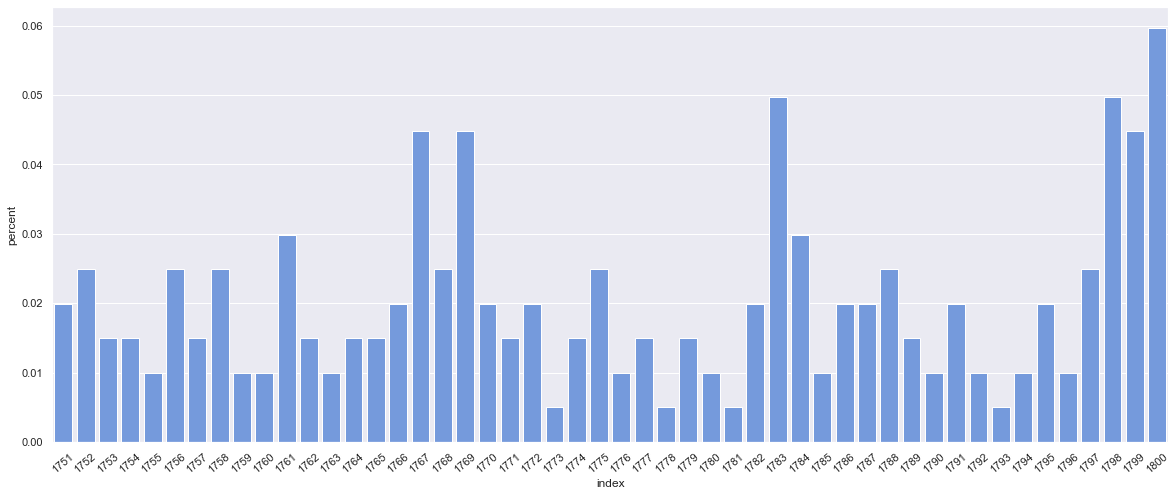

In [30]:
fig, ax = plt.subplots(figsize=(20,8))

bgrf_year_corpus = combined[combined["origin"]=="corpus"]["bgrf_year"].dt.year
bgrf_year_corpus = bgrf_year_corpus.value_counts(normalize=True).reset_index(name="percent")
sns.barplot(x=bgrf_year_corpus["index"], y=bgrf_year_corpus["percent"], color="cornflowerblue")
plt.xticks(rotation=40)


### Publication Date (Wikibase)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 <a list of 50 Text major ticklabel objects>)

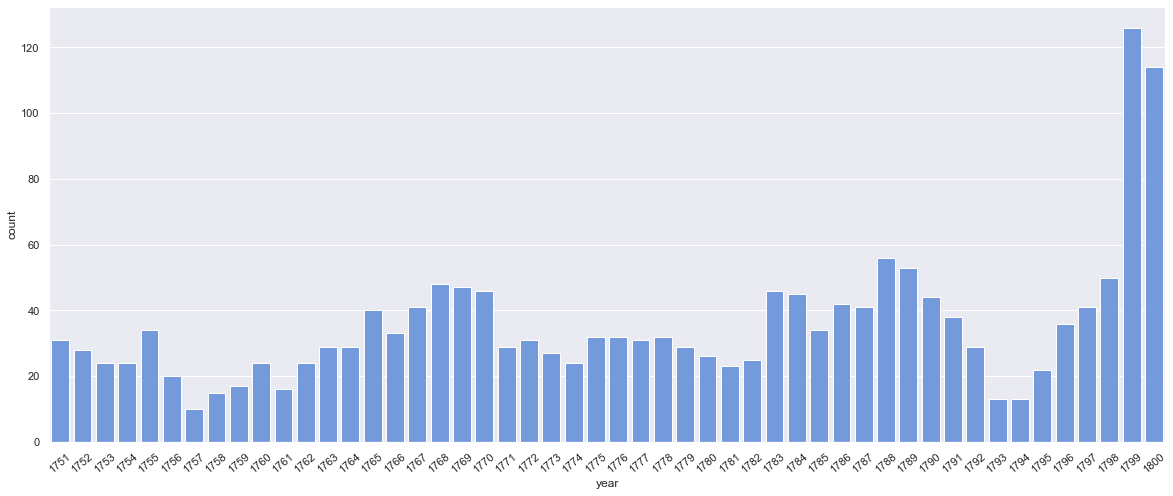

In [31]:
# Publication date
fig, ax = plt.subplots(figsize=(20,8))
plot = sns.countplot(x=combined[combined["origin"] == "wikibase"]["year"].dt.year, color="cornflowerblue")
plt.xticks(rotation=40)

### Comparison Publication Date

In [32]:
# Publication year of corpus texts:
year_corpus = combined[combined["origin"] == "corpus"]['firsted-yr']
# Publication year of BGRF items:
year_wikibase = combined[combined["origin"] == "wikibase"]['year']

# Create a date index which includes the whole data range
# so that we can fill in missing data points.
idx = pd.date_range(start='1751', end='1800', freq='YS', closed=None)

# In previous visualizations we have used absolute value counts.
# For comparison we obviously need to use relative frequencies instead.
df = pd.DataFrame(index=idx)
df['freq_corpus'] = year_corpus.value_counts(normalize=True)
print(df)
df['freq_bgrf'] = year_wikibase.value_counts(normalize=True)
df['year'] = df.index.year
print('The data in "wide form"\n', df.head(4), '\n')

# For the visualization we need the data in "long form", i.e. all the
# relative frequencies are in one single column, with another column 
# specifying whether it stems from the corpus or the bibliography.
long = pd.melt(
    df, id_vars=['year'], value_vars=['freq_corpus', 'freq_bgrf'],
    var_name='origin', value_name='rel_freq')

print('The data in "long form"\n', long.head(4))

            freq_corpus
1751-01-01     0.024876
1752-01-01     0.024876
1753-01-01     0.014925
1754-01-01     0.009950
1755-01-01     0.014925
1756-01-01     0.024876
1757-01-01     0.014925
1758-01-01     0.029851
1759-01-01     0.009950
1760-01-01     0.014925
1761-01-01     0.029851
1762-01-01     0.009950
1763-01-01     0.009950
1764-01-01     0.019900
1765-01-01     0.014925
1766-01-01     0.019900
1767-01-01     0.044776
1768-01-01     0.024876
1769-01-01     0.044776
1770-01-01     0.019900
1771-01-01     0.014925
1772-01-01     0.024876
1773-01-01     0.004975
1774-01-01     0.014925
1775-01-01     0.024876
1776-01-01     0.014925
1777-01-01     0.014925
1778-01-01     0.009950
1779-01-01     0.009950
1780-01-01     0.009950
1781-01-01     0.004975
1782-01-01     0.019900
1783-01-01     0.034826
1784-01-01     0.024876
1785-01-01     0.009950
1786-01-01     0.014925
1787-01-01     0.024876
1788-01-01     0.024876
1789-01-01     0.009950
1790-01-01     0.014925
1791-01-01     0

<ipython-input-32-20dd07ebb314>:8: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  idx = pd.date_range(start='1751', end='1800', freq='YS', closed=None)


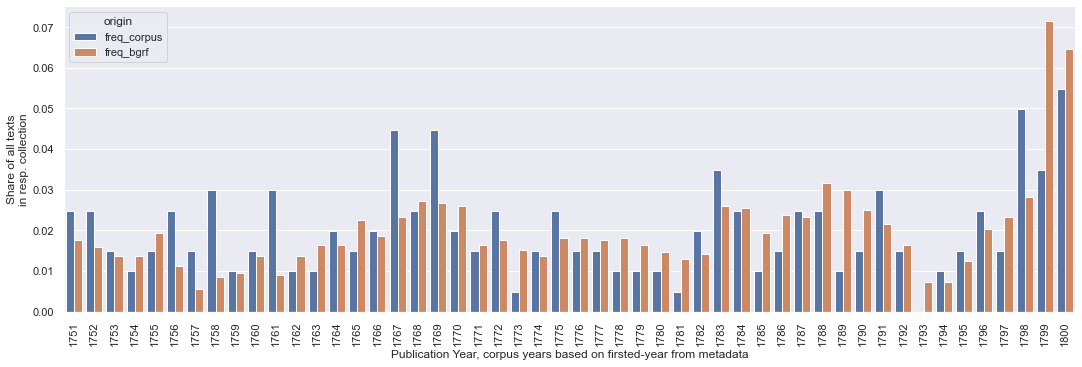

In [33]:
sns.catplot(x='year', y='rel_freq', hue='origin', kind='bar', data=long[long['year'] > 1750], height=5, aspect=3,
           legend_out=False)
plt.xlabel('Publication Year, corpus years based on firsted-year from metadata')
plt.ylabel('Share of all texts\nin resp. collection')
_ = plt.xticks(rotation=90)

Comparison of publication years based on year created on bgrf.

Text(0, 0.5, 'percent')

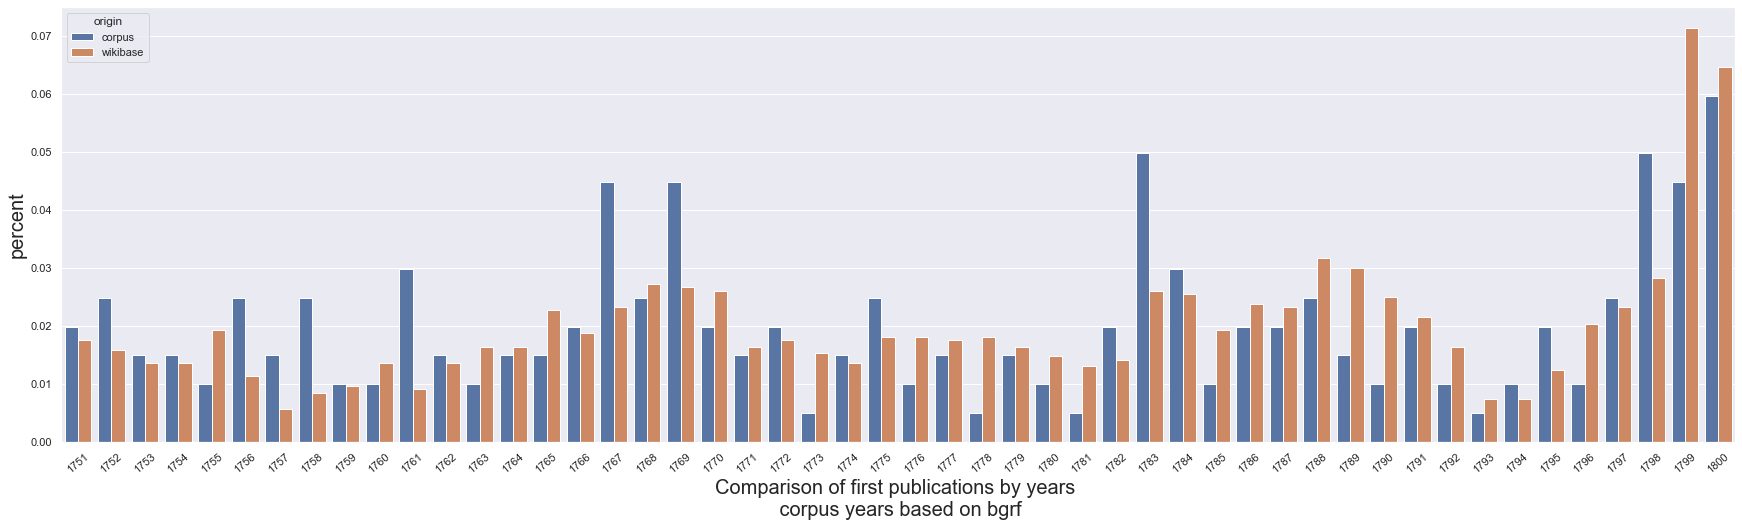

In [34]:

pubyears = combined[["origin", "year"]]
pubyears = pubyears.drop(pubyears[pubyears["year"] == 1801].index)
pubyears_grouped = pubyears.groupby(["origin"]).value_counts(normalize=True).reset_index(name="percentage")

# sort for years for visualization
years = sorted(set(pubyears["year"].dt.year))
fig, ax = plt.subplots(figsize=(30,8))
ax = sns.barplot(x=pubyears_grouped["year"].dt.year, y=pubyears_grouped["percentage"], hue="origin", data=pubyears_grouped, order = years)
plt.xticks(rotation=40)
plt.xlabel("Comparison of first publications by years \n corpus years based on bgrf", fontsize=20)
plt.ylabel("percent", fontsize=20)

## Narrative Form

### Narrative form corpus
Data is in the column 'form'. Possible values include `'mixed'`, `'autodiegetic'`, `'heterodiegetic'`, `'homodiegetic'`, `'epistolary'`, `'dialogue novel'` and also `NaN`.

Set of all values:  {'heterodiegetic', 'unknown', 'epistolary', 'mixed', 'dialogue novel', 'autodiegetic', 'homodiegetic'}
% of mixed: 	0.045
% of autodiegetic: 	0.254
% of heterodiegetic: 	0.443
% of homodiegetic: 	0.025
% of epistolary: 	0.194
% of dialogue novel: 	0.030


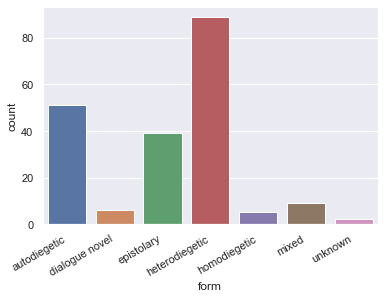

In [35]:
form = corpus['form'].astype('category')
print('Set of all values: ', set(form.values))
print('\n'.join([
    f'% of {kind}: \t{((form==kind).sum()/form.count()):.3f}'
    for kind in [
        'mixed', 'autodiegetic', 'heterodiegetic', 'homodiegetic',
        'epistolary', 'dialogue novel'
    ]
]))
plot = sns.countplot(x=form)
_ = plt.xticks(rotation=30, horizontalalignment='right')

### Narrative Form (Wikibase)

In the wikibase data some of the narrative forms are written a little different like dialogue novel vs. dialugue. In order to compare both the Wikibase-Data and the Metadata we will have to align those.

In [36]:
combined["form"] = combined["form"].map(lambda x: "dialogue novel" if x == "dialogue" else x)
print(combined.groupby(["origin", "form"])["form"].count())

origin    form          
corpus    autodiegetic       51
          dialogue novel      6
          epistolary         39
          heterodiegetic     89
          homodiegetic        5
          mixed               9
          unknown             2
wikibase  autodiegetic      398
          dialogue novel      9
          epistolary        203
          heterodiegetic    633
          homodiegetic       13
          mixed              61
          unknown           447
Name: form, dtype: int64


Plot narrative forms from Wikibase.

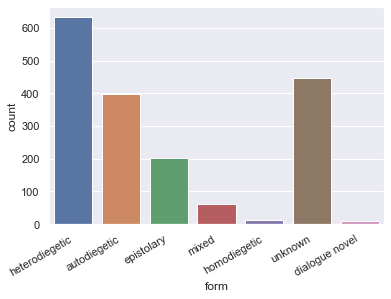

In [37]:
narrform_bgrf = combined[combined["origin"] == "wikibase"]["form"].reset_index()
plot = sns.countplot(x=narrform_bgrf['form'])
_ = plt.xticks(rotation=30, horizontalalignment='right')

## Comparison

### Narrative Form (Corpus vs BGRF)

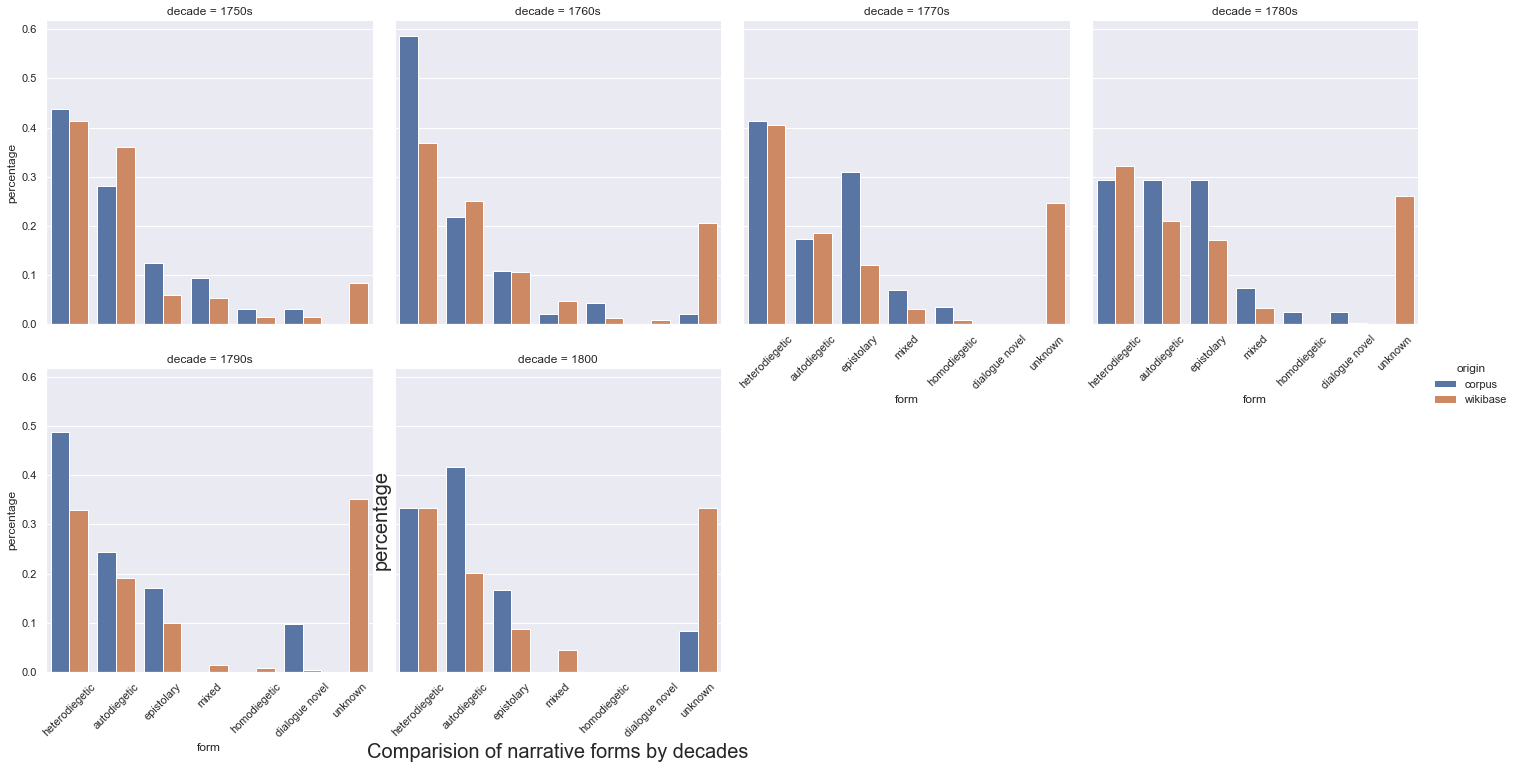

In [38]:
## comparison of the narrative forms by decade

narr_form_grouped = combined[["origin", "decade", "form"]].groupby(["origin", "decade"]).value_counts(normalize=True).reset_index(name="percentage")

ax = sns.catplot(x="form", y="percentage", col="decade", hue="origin", col_wrap=4, data=narr_form_grouped, kind="bar")
plt.xticks(rotation=90)
plt.xlabel("Comparision of narrative forms by decades", fontsize=20)
plt.ylabel("percentage", fontsize=20)
ax.set_xticklabels(rotation=45)

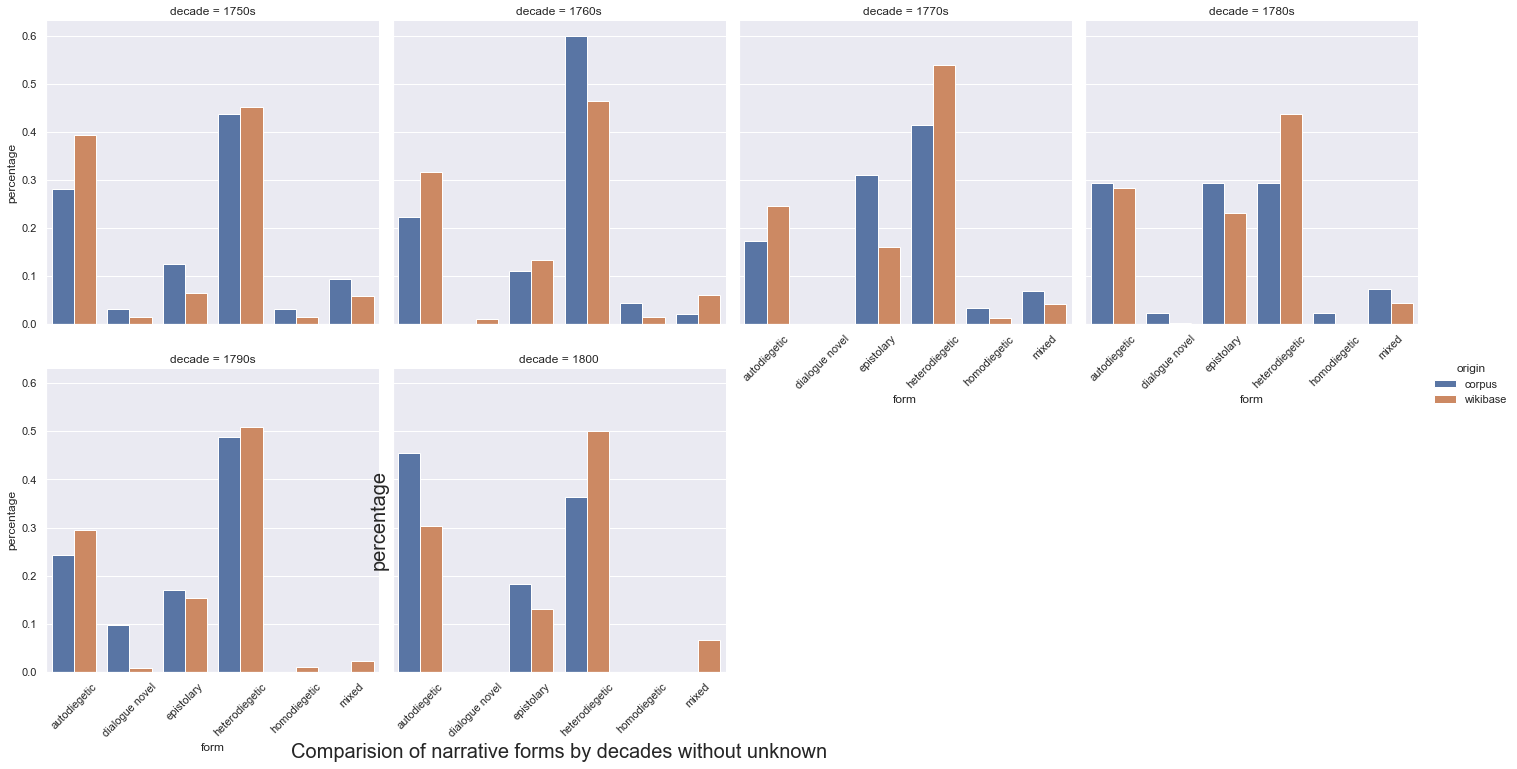

In [39]:
## drop unknown:
narr_form_combined = combined[["form", "decade", "origin"]]
narr_form_combined_wo_unknown = narr_form_combined.drop(narr_form_combined[(narr_form_combined["form"] == "unknown")].index)

narr_form_grouped_wo_unknwon = narr_form_combined_wo_unknown[["origin", "decade", "form"]].groupby(["origin", "decade"]).value_counts(normalize=True, sort=False).reset_index(name="percentage")

ax = sns.catplot(x="form", y="percentage", col="decade", hue="origin",col_wrap=4, data=narr_form_grouped_wo_unknwon, kind="bar")
plt.xticks(rotation=90)
plt.xlabel("Comparision of narrative forms by decades without unknown", fontsize=20)
plt.ylabel("percentage", fontsize=20)
ax.set_xticklabels(rotation=45)

Narrative forms by gender in corpus

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text major ticklabel objects>)

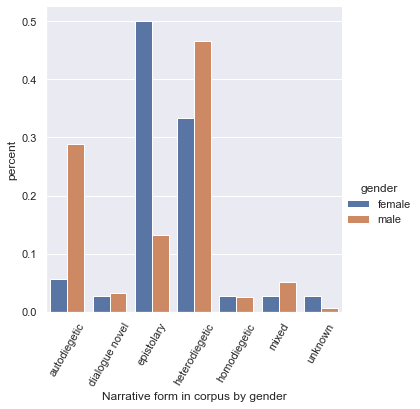

In [40]:
authors_narr_grouped = combined[combined["origin"] == "corpus"][["form", "gender"]]

authors_narr_grouped = authors_narr_grouped.drop(authors_narr_grouped[(authors_narr_grouped["gender"] == "unknown")].index)

authors_narr_grouped = authors_narr_grouped.groupby(["gender"]).value_counts(normalize=True, sort=False).reset_index(name="percent")


ax = sns.catplot(x="form", y="percent",  hue="gender", data=authors_narr_grouped, kind="bar")
plt.xlabel("Narrative form in corpus by gender")
plt.xticks(rotation=60)

Narrative forms by gender in wikibase

    gender            form   percent
0   female  heterodiegetic  0.367521
1   female      epistolary  0.243590
2   female         unknown  0.226496
3   female    autodiegetic  0.106838
4   female           mixed  0.042735
5   female    homodiegetic  0.008547
6   female  dialogue novel  0.004274
7     male  heterodiegetic  0.371175
8     male         unknown  0.261599
9     male    autodiegetic  0.229023
10    male      epistolary  0.097730
11    male           mixed  0.028628
12    male    homodiegetic  0.006910
13    male  dialogue novel  0.004936


(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text major ticklabel objects>)

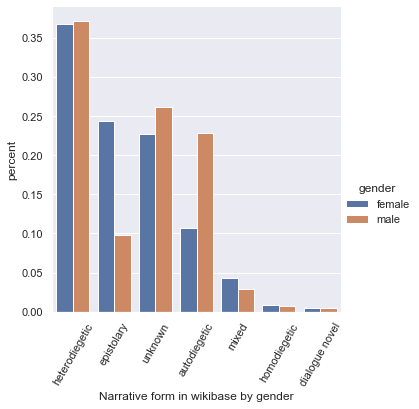

In [41]:
authors_narr_grouped_w = combined[combined["origin"] == "wikibase"][["form", "gender"]]

authors_narr_grouped_w = authors_narr_grouped_w.drop(authors_narr_grouped_w[(authors_narr_grouped_w["gender"] == "unknown")].index)

authors_narr_grouped_w = authors_narr_grouped_w.groupby(["gender"]).value_counts(normalize=True).reset_index(name="percent")
print(authors_narr_grouped_w)

ax = sns.catplot(x="form", y="percent",  hue="gender", data=authors_narr_grouped_w, kind="bar")
plt.xlabel("Narrative form in wikibase by gender")
plt.xticks(rotation=60)

### Narrative Form: Author gender wikibase and corpus comparison

Text(0.5, 0.98, 'Narrative form in corpus and wikibase by gender')

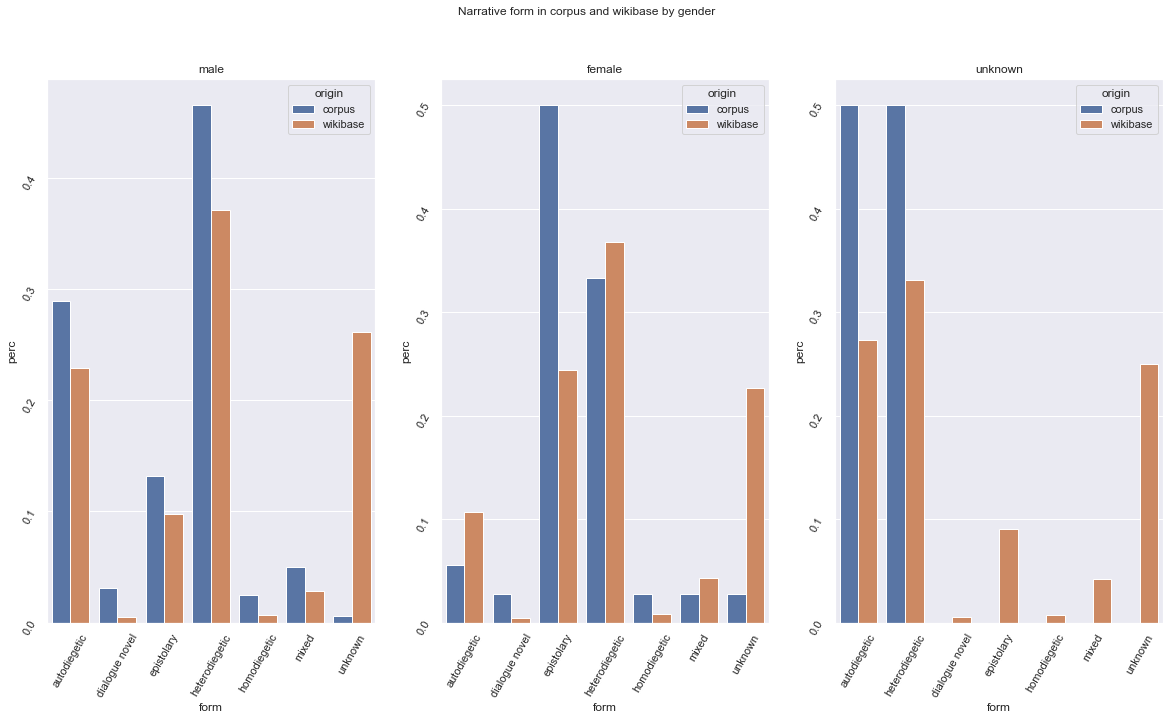

In [42]:
authors_gender_narr = combined[["gender", "origin", "form"]]
authors_gender_narr_grouped = authors_gender_narr[["origin", "form", "gender"]].groupby(["origin", "gender"]).value_counts(normalize=True, sort=False).reset_index(name="perc")

fig, axes = plt.subplots(1,3, figsize=(20,10))
ax1 = sns.barplot(x="form", y="perc",  hue="origin", data=authors_gender_narr_grouped[authors_gender_narr_grouped["gender"] == "male"], ax=axes[0])
axes[0].set_title("male")
ax2 = sns.barplot(x="form", y="perc",  hue="origin", data=authors_gender_narr_grouped[authors_gender_narr_grouped["gender"] == "female"], ax=axes[1])
axes[1].set_title("female")
ax3 = sns.barplot(x="form", y="perc",  hue="origin", data=authors_gender_narr_grouped[authors_gender_narr_grouped["gender"] == "unknown"], ax=axes[2])
axes[2].set_title("unknown")
#axes.xlabel("Narrative form in corpus and wikibase by gender")
for ax in fig.axes:
    ax.tick_params(rotation=60)
fig.suptitle("Narrative form in corpus and wikibase by gender")

Same plot, but without the unknown gender.

      gender    origin            form
0       male    corpus      epistolary
1       male    corpus  heterodiegetic
2       male    corpus  heterodiegetic
3       male    corpus  heterodiegetic
4       male    corpus    autodiegetic
...      ...       ...             ...
1960    male  wikibase         unknown
1961  female  wikibase  heterodiegetic
1962    male  wikibase  heterodiegetic
1963    male  wikibase    autodiegetic
1964    male  wikibase         unknown

[1442 rows x 3 columns]


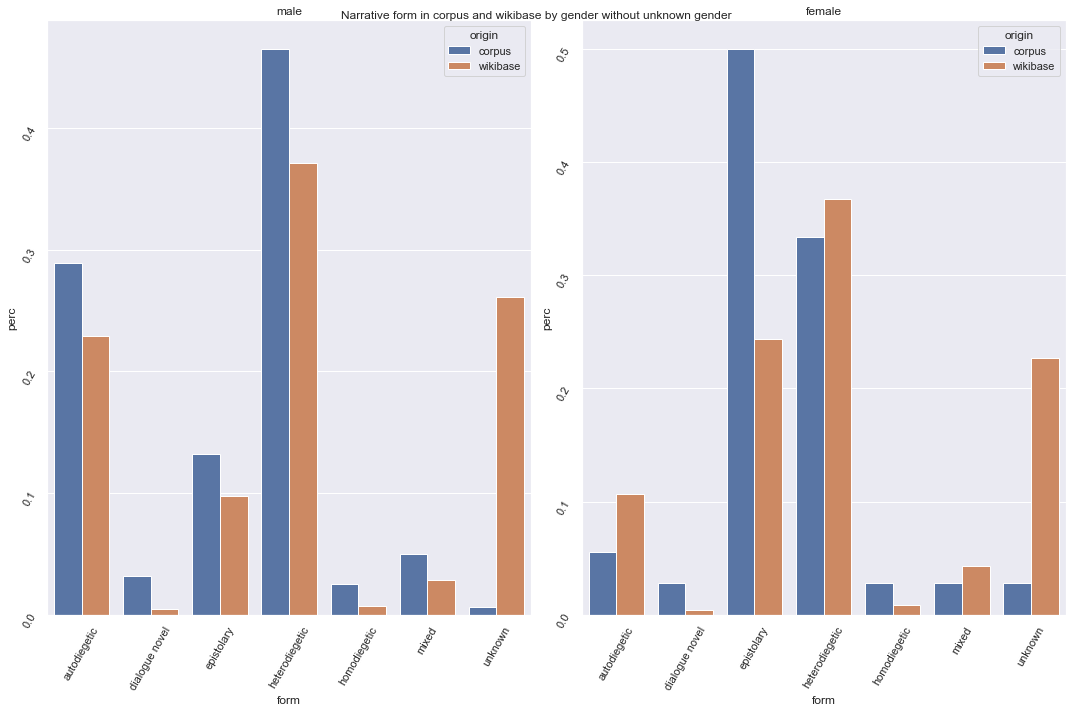

In [43]:
authors_gender_narr_without_unknown = authors_gender_narr[authors_gender_narr["gender"] != "unknown"]
print(authors_gender_narr_without_unknown)
authors_gender_narr_without_unknown = authors_gender_narr_without_unknown[["origin", "form", "gender"]].groupby(["origin", "gender"]).value_counts(normalize=True, sort=False).reset_index(name="perc")
#print(authors_gender_narr_without_unknwon_grouped)
fig, axes = plt.subplots(1, 2, figsize=(15,10))
ax1 = sns.barplot(x="form", y="perc",  hue="origin", data=authors_gender_narr_without_unknown[authors_gender_narr_without_unknown["gender"] == "male"], ax=axes[0])
axes[0].set_title("male")
ax2 = sns.barplot(x="form", y="perc",  hue="origin", data=authors_gender_narr_without_unknown[authors_gender_narr_without_unknown["gender"] == "female"], ax=axes[1])
axes[1].set_title("female")

for ax in fig.axes:
    ax.tick_params(rotation=60)
fig.suptitle("Narrative form in corpus and wikibase by gender without unknown gender")
plt.tight_layout()

### Further comparisons

Now let's do some futher comparisons. These will be used internally to check how balanced the corpus is. Therefore we will copy the dataframe once more and drop items that "empty" cells.

In [44]:
wikib = combined[combined["origin"] == "wikibase"][["form", "gender", "decade"]].copy()

wikib = wikib.dropna()

In [45]:
wikib = wikib.groupby(["decade","form", "gender"], dropna=False).value_counts().reset_index(name="counts_wikib")
print(wikib["counts_wikib"].sum())
wikib["anteil_wikibase"] = wikib.apply(lambda x: x.counts_wikib / wikib["counts_wikib"].sum(), axis=1)
wikib = wikib.rename(columns={"dialogue novel": "dialog"})
print(wikib)

1764
    decade            form   gender  counts_wikib  anteil_wikibase
0    1750s    autodiegetic   female             4         0.002268
1    1750s    autodiegetic     male            42         0.023810
2    1750s    autodiegetic  unknown            27         0.015306
3    1750s  dialogue novel   female             1         0.000567
4    1750s  dialogue novel     male             1         0.000567
..     ...             ...      ...           ...              ...
98    1800           mixed   female             2         0.001134
99    1800           mixed     male             1         0.000567
100   1800           mixed  unknown             2         0.001134
101   1800         unknown     male            19         0.010771
102   1800         unknown  unknown            19         0.010771

[103 rows x 5 columns]


In [46]:
meta = combined[combined["origin"] == "corpus"][["form", "gender", "decade"]].copy()
print("meta: ", len(meta), meta.columns.to_list())

meta = meta.dropna()
print(len(meta))

meta:  201 ['form', 'gender', 'decade']
201


In [47]:
meta = meta.groupby(["decade", "form", "gender"], dropna=False).value_counts().reset_index(name="counts_meta")
print(meta["counts_meta"].sum())
print(meta.head())

201
  decade            form  gender  counts_meta
0  1750s    autodiegetic    male            9
1  1750s  dialogue novel    male            1
2  1750s      epistolary  female            3
3  1750s      epistolary    male            1
4  1750s  heterodiegetic  female            3


In [48]:
meta["anteil_corpus"] = meta.apply(lambda x: x.counts_meta / meta["counts_meta"].sum(), axis=1)

In [49]:
result = pd.merge(wikib, meta, how="outer", on=["form", "gender", "decade"]).fillna(0)
result

,decade,form,gender,counts_wikib,anteil_wikibase,counts_meta,anteil_corpus
0,1750s,autodiegetic,female,4.0,0.002268,0.0,0.000000
1,1750s,autodiegetic,male,42.0,0.023810,9.0,0.044776
2,1750s,autodiegetic,unknown,27.0,0.015306,0.0,0.000000
3,1750s,dialogue novel,female,1.0,0.000567,0.0,0.000000
4,1750s,dialogue novel,male,1.0,0.000567,1.0,0.004975
...,...,...,...,...,...,...,...
100,1800,mixed,unknown,2.0,0.001134,0.0,0.000000
101,1800,unknown,male,19.0,0.010771,1.0,0.004975
102,1800,unknown,unknown,19.0,0.010771,0.0,0.000000
103,1780s,dialogue novel,female,0.0,0.000000,1.0,0.004975


In [50]:
result["result"] = result.apply(lambda x: "too few" if x.anteil_wikibase > x.anteil_corpus else "too many", axis=1)

In [51]:
resulttest = result.copy()
combined_t = combined.copy()
resulttest

,decade,form,gender,counts_wikib,anteil_wikibase,counts_meta,anteil_corpus,result
0,1750s,autodiegetic,female,4.0,0.002268,0.0,0.000000,too few
1,1750s,autodiegetic,male,42.0,0.023810,9.0,0.044776,too many
2,1750s,autodiegetic,unknown,27.0,0.015306,0.0,0.000000,too few
3,1750s,dialogue novel,female,1.0,0.000567,0.0,0.000000,too few
4,1750s,dialogue novel,male,1.0,0.000567,1.0,0.004975,too many
...,...,...,...,...,...,...,...,...
100,1800,mixed,unknown,2.0,0.001134,0.0,0.000000,too few
101,1800,unknown,male,19.0,0.010771,1.0,0.004975,too few
102,1800,unknown,unknown,19.0,0.010771,0.0,0.000000,too few
103,1780s,dialogue novel,female,0.0,0.000000,1.0,0.004975,too many


wikitest 
                       anteil_wikibase                    
gender                         female      male   unknown
decade form                                              
1750s  autodiegetic          0.002268  0.023810  0.015306
       dialogue novel        0.000567  0.000567  0.000567
       epistolary            0.002268  0.003968  0.000567
       heterodiegetic        0.011338  0.026077  0.010204
       homodiegetic          0.000000  0.000567  0.001134
       mixed                 0.000000  0.003968  0.002268
       unknown               0.001701  0.006236  0.001701
1760s  autodiegetic          0.003968  0.026644  0.016440
       dialogue novel        0.000000  0.001134  0.000567
       epistolary            0.005669  0.008503  0.005669
       heterodiegetic        0.006236  0.042517  0.020408
       homodiegetic          0.001134  0.000567  0.000567
       mixed                 0.001134  0.004535  0.003401
       unknown               0.003401  0.026077  0.009070
177

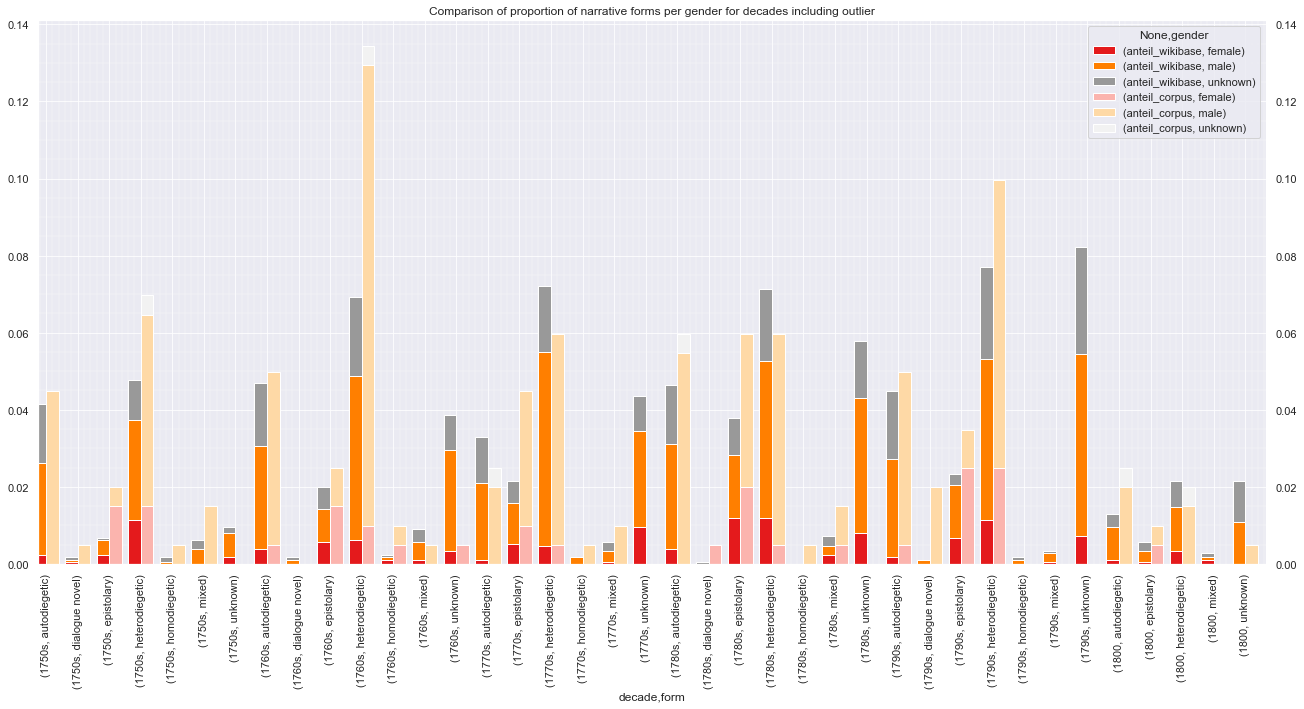

In [52]:
def plot_balancing_years(resulttest, how):
    genders = ["male", "female", "unknown"]
    forms = resulttest["form"].unique()

    resulttest = resulttest.drop(columns=["result", "counts_meta"])

    if how == "outlier_data":
        ## as there are many novels in the wikibase that have only one match for the combination of gender, form and decade, we will drop those
        wikitest = resulttest.copy()
        wikitest["anteil_wikibase"] = wikitest.apply(lambda x: x["anteil_wikibase"] if x["counts_wikib"] > 1 else 0, axis=1)
        wikitest = wikitest.drop(columns=["counts_wikib"])
    elif how == "all_data":
        ## use all_data if you want to visualize all data, including the outliers
        wikitest = resulttest.drop(columns=["counts_wikib"])

    wikitest = wikitest.drop(columns=["anteil_corpus"])
    wikitest = wikitest.pivot_table(index=["decade","form"], columns=["gender"], fill_value=0)
    print("wikitest", "\n", wikitest)
    corpusresulttest = resulttest.drop(columns=["anteil_wikibase", "counts_wikib"])
    corpusresulttest = corpusresulttest.pivot_table(index=["decade","form"], columns=["gender"], fill_value=0)
    print("corpusresulttest", "\n", corpusresulttest)

    # plotting
    fig, ax = plt.subplots(figsize=(22,10))
    ax.grid(which="major", linewidth=0.8)
    ax.grid(which="minor", linewidth=0.3)
    ax.minorticks_on()
    
    wikitest.plot.bar(stacked=True, position=1, width=0.4, ax= ax, colormap="Set1")
    ax.tick_params(labelright=True)

    ax1 = corpusresulttest.plot.bar(stacked=True, ax=ax, position=0, width=0.4, colormap="Pastel1")
    if how == "all_data":
        plt.title("Comparison of proportion of narrative forms per gender for decades including outlier")
    else:
        plt.title("Comparison of proportion of narrative forms per gender for decades without outlier")

decades = combined_t["decade"].unique()
how = ["all_data", "outlier_data"]
plot_balancing_years(resulttest, how[0])